In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import igraph as ig
import gravis as gv
import networkx as nx
#import leidenalg as la

from matplotlib import rc
from functions import clean_address, es_diagonal_cero, propiedades, centralidades, centralizacion

In [2]:
dfa = pd.read_excel("../Datasets/Research_status_2017_2022.xlsx")

In [3]:
top = ['Multidisciplinary', 'Particles & Fields', 'Applied', 'Condensed Matter', 'Mathematical', 'Molecular & Chemical', 'Physical', 'Astronomy & Astrophysics', 'Fluids & Plasmas']
anios = [2017, 2018, 2019, 2020, 2021, 2022]

## Todos los años

In [4]:
dfe = dfa.copy()
dfe = dfe[['Language', 'Affiliations', 'Document Type', 'Addresses', 'Publication Year', 'WoS Categories']]
dfe = dfe.dropna(subset = ['Addresses', 'Affiliations'])
dfe = dfe[dfe['Document Type']=='Article']
dfe = dfe[dfe['Publication Year']<2023]
dfe["Addresses"] = dfe["Addresses"].apply(lambda x: re.sub(r'\[.*?\]', '', x))
dfe['Addresses'] = dfe['Addresses'].apply(lambda x: x + ';')
dfe['Countries'] = dfe['Addresses'].apply(lambda x: '; '.join(re.findall(r', ([A-Z][a-z]+);', x)))
pattern = re.compile(r'USA|Peoples R China|BELARUS|Korea|Czech Republic|U Arab Emirates|South Africa|Ireland')

dfe = dfe[~dfe['Addresses'].str.contains(r', [A-Z][a-z]+ [A-Z][a-z]+;', regex=True)]
dfe = dfe[~dfe['Addresses'].str.contains(pattern)]
dfe['Paises'] = dfe['Countries'].apply(clean_address)
dfe['Categorias'] = dfe['WoS Categories'].apply(clean_address)
dfe['Type'] = dfe['Document Type'].apply(clean_address)

dfe = dfe[dfe['Categorias'].apply(lambda x: all(item in top for item in x))]
dfe = dfe[dfe['Paises'].apply(lambda x: len(x) == 1 and x[0] == 'Colombia')]


In [5]:
dfAll = dfe
dfAll['Instituciones'] = dfAll['Affiliations'].str.split(';', expand=False)
dfAll['Instituciones'] = dfAll['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfAll['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfAll['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adjAll = adj_matrix.to_numpy()
adjAll = adjAll.astype(float)

InstA = nx.Graph()

for countries in dfAll['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                InstA.add_edge(countries[i], countries[j], weight=adjAll[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(InstA)
nx.set_node_attributes(InstA, c, 'betweenness')


fig = gv.d3(InstA, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

print(len(all_inst))

39


In [6]:
print(propiedades(InstA))

Graph with 36 nodes and 76 edges
N de Nodos:  36
N de aristas:  76
Es direccionado:  False
Transitividad 0.23156089193825044
Centralización  0.017959183673469388
Tiene:  6 comunidades
[frozenset({'Universidad El Bosque', 'Servicio Nacional de Aprendizaje', 'Universidad Autonoma de Occidente', 'Universidad Nacional de Colombia', 'Universidad Autonoma de Manizales', 'Universidad Militar Nueva Granada', 'Universidad La Gran Colombia', 'Universidad Pedagogica y Tecnologica de Colombia (UPTC)', 'Universidad del Magdalena'}), frozenset({'Universidad del Cauca', 'Universidad ICESI', 'Universidad del Valle', 'Universidad del Tolima', 'Universidad del Quindio', 'Pontificia Universidad Javeriana', 'Universidad Manuela Beltran - UMB', 'Universidad Santiago de Cali'}), frozenset({'Universidad Antonio Narino', 'Corporacion Colombiana de Investigacion Agropecuaria, AGROSAVIA', 'Corporacion Universitaria Minuto de Dios (UNIMINUTO)', 'Universidad de Antioquia', 'Universidad Cooperativa de Colombia', '

### 2017

In [7]:
dfe2017 = dfe[dfe['Publication Year']==2017].copy()
dfe2017['Instituciones'] = dfe2017['Affiliations'].str.split(';', expand=False)
dfe2017['Instituciones'] = dfe2017['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2017['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2017['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2017 = nx.Graph()

for countries in dfe2017['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            graph2017.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])



c = nx.algorithms.degree_centrality(graph2017)
nx.set_node_attributes(graph2017, c, 'betweenness')


labels = {node: node for node in graph2017.nodes()}
fig = gv.d3(graph2017, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2017 = centralidades(graph2017)
cent_grado = centr2017['centralidad'].head(20)
centralizacion2017 = centralizacion(graph2017)
densidad2017 = nx.density(graph2017)
asort2017 = nx.degree_assortativity_coefficient(graph2017)
trans2017 = nx.transitivity(graph2017)

In [8]:
print(propiedades(graph2017))

Graph with 15 nodes and 17 edges
N de Nodos:  15
N de aristas:  17
Es direccionado:  False
Transitividad 0.1111111111111111
Centralización  0.033751962323390894
Tiene:  4 comunidades
[frozenset({'Universidad de Medellin', 'Universidad de los Andes (Colombia)', 'Pontificia Universidad Javeriana', 'Universidad Industrial de Santander', 'Universidad de La Sabana'}), frozenset({'Universidad La Gran Colombia', 'Universidad Nacional de Colombia', 'Universidad Pedagogica y Tecnologica de Colombia (UPTC)', 'Universidad del Rosario'}), frozenset({'Universidad de Caldas', 'Universidad de Antioquia', 'Universidad EAFIT'}), frozenset({'Universidad Antonio Narino', 'Universidad del Valle', 'Universidad Militar Nueva Granada'})]
Densidad: 0.1619047619047619
None


### 2018

In [9]:
dfe2018 = dfe[dfe['Publication Year']==2018].copy()
dfe2018['Instituciones'] = dfe2018['Affiliations'].str.split(';', expand=False)
dfe2018['Instituciones'] = dfe2018['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2018['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2018['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2018 = nx.Graph()

for countries in dfe2018['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2018.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2018)
nx.set_node_attributes(graph2018, c, 'betweenness')


labels = {node: node for node in graph2018.nodes()}
fig = gv.d3(graph2018, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2018 = centralidades(graph2018)
cent_grado = centr2018['centralidad'].head(20)
centralizacion2018 = centralizacion(graph2018)
densidad2018 = nx.density(graph2018)
asort2018 = nx.degree_assortativity_coefficient(graph2018)
trans2018 = nx.transitivity(graph2018)

In [10]:
print(propiedades(graph2018))

Graph with 18 nodes and 23 edges
N de Nodos:  18
N de aristas:  23
Es direccionado:  False
Transitividad 0.28378378378378377
Centralización  0.02508650519031142
Tiene:  3 comunidades
[frozenset({'Universidad Antonio Narino', 'Universidad de Medellin', 'Universidad de Antioquia', 'Universidad Industrial de Santander', 'Universidad Distrital Francisco Jose de Caldas', 'Universidad Nacional de Colombia', 'Universidad Pedagogica y Tecnologica de Colombia (UPTC)', 'Universidad Santiago de Cali', 'Universidad del Magdalena'}), frozenset({'Universidad del Valle', 'Universidad Militar Nueva Granada', 'Pontificia Universidad Javeriana', 'Universidad del Cauca', 'Universidad del Norte Colombia', 'Universidad Manuela Beltran - UMB'}), frozenset({'Universidad de La Sabana', 'Clinica del Country - Unidad Medica', 'Universidad de los Andes (Colombia)'})]
Densidad: 0.1503267973856209
None


### 2019

In [11]:
dfe2019 = dfe[dfe['Publication Year'] == 2019].copy()
dfe2019['Instituciones'] = dfe2019['Affiliations'].str.split(';', expand=False)
dfe2019['Instituciones'] = dfe2019['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2019['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2019['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2019 = nx.Graph()

for countries in dfe2019['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2019.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2019)
nx.set_node_attributes(graph2019, c, 'betweenness')


labels = {node: node for node in graph2019.nodes()}
fig = gv.d3(graph2019, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2019 = centralidades(graph2019)
cent_grado = centr2019['centralidad'].head(20)
centralizacion2019 = centralizacion(graph2019)
densidad2019 = nx.density(graph2019)
asort2019 = nx.degree_assortativity_coefficient(graph2019)
trans2019 = nx.transitivity(graph2019)

In [12]:
print(propiedades(graph2019))

Graph with 17 nodes and 19 edges
N de Nodos:  17
N de aristas:  19
Es direccionado:  False
Transitividad 0.14754098360655737
Centralización  0.029947916666666668
Tiene:  3 comunidades
[frozenset({'Universidad Antonio Narino', 'Universidad del Valle', 'Universidad del Tolima', 'Universidad del Quindio', 'Universidad del Cauca', 'Universidad Tecnologica de Pereira', 'Universidad de Cartagena'}), frozenset({'Corporacion Colombiana de Investigacion Agropecuaria, AGROSAVIA', 'Universidad Nacional de Colombia', 'Universidad de Antioquia', 'Pontificia Universidad Javeriana', 'Universidad Cooperativa de Colombia', 'Universidad Distrital Francisco Jose de Caldas', 'Universidad Pedagogica y Tecnologica de Colombia (UPTC)'}), frozenset({'Universidad Industrial de Santander', 'Universidad de los Andes (Colombia)', 'Universidad del Rosario'})]
Densidad: 0.13970588235294118
None


### 2020

In [13]:
dfe2020 = dfe[dfe['Publication Year']==2020].copy()
dfe2020['Instituciones'] = dfe2020['Affiliations'].str.split(';', expand=False)
dfe2020['Instituciones'] = dfe2020['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2020['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2020['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2020 = nx.Graph()

for countries in dfe2020['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2020.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2020)
nx.set_node_attributes(graph2020, c, 'betweenness')


labels = {node: node for node in graph2020.nodes()}
fig = gv.d3(graph2020, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2020 = centralidades(graph2020)
cent_grado = centr2020['centralidad'].head(20)
centralizacion2020 = centralizacion(graph2020)
densidad2020 = nx.density(graph2020)
asort2020 = nx.degree_assortativity_coefficient(graph2020)
trans2020 = nx.transitivity(graph2020)

In [14]:
print(propiedades(graph2020))

Graph with 20 nodes and 24 edges
N de Nodos:  20
N de aristas:  24
Es direccionado:  False
Transitividad 0.14457831325301204
Centralización  0.026469682979378264
Tiene:  4 comunidades
[frozenset({'Universidad El Bosque', 'Universidad Nacional de Colombia', 'Universidad del Quindio', 'Universidad Autonoma de Manizales', 'Universidad de los Andes (Colombia)', 'Universidad Pedagogica y Tecnologica de Colombia (UPTC)', 'Universidad de Cartagena', 'Universidad del Magdalena'}), frozenset({'Universidad Antonio Narino', 'Universidad del Valle', 'Universidad Militar Nueva Granada', 'Universidad Cooperativa de Colombia', 'Pontificia Universidad Javeriana', 'Universidad del Cauca'}), frozenset({'Universidad Industrial de Santander', 'Universidad de Antioquia', 'Universidad EAFIT'}), frozenset({'Universidad Distrital Francisco Jose de Caldas', 'Universidad Tecnologica de Pereira', 'Universidad Tecnologica de Bolivar'})]
Densidad: 0.12631578947368421
None


### 2021


In [15]:
dfe2021 = dfe[dfe['Publication Year']==2021].copy()
dfe2021['Instituciones'] = dfe2021['Affiliations'].str.split(';', expand=False)
dfe2021['Instituciones'] = dfe2021['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2021['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2021['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2021 = nx.Graph()

for countries in dfe2021['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2021.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2021)
nx.set_node_attributes(graph2021, c, 'betweenness')


labels = {node: node for node in graph2021.nodes()}
fig = gv.d3(graph2021, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)

centr2021 = centralidades(graph2021)
cent_grado = centr2021['centralidad'].head(20)
centralizacion2021 = centralizacion(graph2021)
densidad2021 = nx.density(graph2021)
asort2021 = nx.degree_assortativity_coefficient(graph2021)
trans2021 = nx.transitivity(graph2021)


In [16]:
print(propiedades(graph2021))

Graph with 23 nodes and 29 edges
N de Nodos:  23
N de aristas:  29
Es direccionado:  False
Transitividad 0.2857142857142857
Centralización  0.012396694214876035
Tiene:  3 comunidades
[frozenset({'Universidad del Cauca', 'Universidad Industrial de Santander', 'Universidad Distrital Francisco Jose de Caldas', 'Universidad del Norte Colombia', 'Universidad Tecnologica de Bolivar', 'Universidad del Valle', 'Universidad Francisco de Paula Santander', 'Universidad Santiago de Cali', 'Universidad de Cartagena'}), frozenset({'Universidad Autonoma de Occidente', 'Universidad Nacional de Colombia', 'Universidad del Tolima', 'Universidad del Quindio', 'Universidad Autonoma de Manizales', 'Servicio Nacional de Aprendizaje', 'Universidad Tecnologica de Pereira'}), frozenset({'Universidad Antonio Narino', 'Universidad de Antioquia', 'Universidad Militar Nueva Granada', 'Corporacion Universitaria Minuto de Dios (UNIMINUTO)', 'Universidad de los Andes (Colombia)', 'Universidad Pedagogica y Tecnologica

### 2022

In [17]:
dfe2022 = dfe[dfe['Publication Year']==2022].copy()
dfe2022['Instituciones'] = dfe2022['Affiliations'].str.split(';', expand=False)
dfe2022['Instituciones'] = dfe2022['Instituciones'].apply(lambda inst: [i.strip() for i in inst])

all_inst = set()
for inst in dfe2022['Instituciones']:
    all_inst.update(inst)
all_inst = sorted(list(all_inst))
adj_matrix = pd.DataFrame(0, index=all_inst, columns=all_inst)
for countries in dfe2022['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i+1, len(countries)):
            adj_matrix.loc[countries[i], countries[j]] += 1
            adj_matrix.loc[countries[j], countries[i]] += 1
adj = adj_matrix.to_numpy()
adj = adj.astype(float)

graph2022 = nx.Graph()

for countries in dfe2022['Instituciones']:
    countries = sorted(countries)
    for i in range(len(countries)):
        for j in range(i + 1, len(countries)):
            if countries[i] != countries[j]:  # Agregar esta condición para evitar bucles
                graph2022.add_edge(countries[i], countries[j], weight=adj[all_inst.index(countries[i])][all_inst.index(countries[j])])

c = nx.algorithms.degree_centrality(graph2022)
nx.set_node_attributes(graph2022, c, 'betweenness')


labels = {node: node for node in graph2022.nodes()}
fig = gv.d3(graph2022, use_node_size_normalization=True, 
            node_size_normalization_max = 100,      
            use_edge_size_normalization = True, 
            edge_size_data_source = 'weight', 
            edge_curvature = 0.4)


centr2022 = centralidades(graph2022)
cent_grado = centr2022['centralidad'].head(20)
centralizacion2022 = centralizacion(graph2022)
densidad2022 = nx.density(graph2022)
asort2022 = nx.degree_assortativity_coefficient(graph2022)
trans2022 = nx.transitivity(graph2022)

In [18]:
print(propiedades(graph2022))

Graph with 21 nodes and 19 edges
N de Nodos:  21
N de aristas:  19
Es direccionado:  False
Transitividad 0.1
Centralización  0.019868421052631584
Tiene:  5 comunidades
[frozenset({'Servicio Nacional de Aprendizaje', 'Universidad Distrital Francisco Jose de Caldas', 'Universidad de los Andes (Colombia)', 'Universidad del Norte Colombia', 'Universidad Nacional de Colombia', 'Universidad del Tolima', 'Universidad de Caldas', 'Universidad del Magdalena'}), frozenset({'Universidad Antonio Narino', 'Universidad del Valle', 'Universidad del Quindio', 'Pontificia Universidad Javeriana', 'Universidad del Cauca', 'Universidad ICESI', 'Universidad Santiago de Cali'}), frozenset({'Universidad de Antioquia', 'Universidad Pedagogica y Tecnologica de Colombia (UPTC)'}), frozenset({'Corporacion Universitaria Minuto de Dios (UNIMINUTO)', 'Universidad Cooperativa de Colombia'}), frozenset({'Universidad Tecnologica de Pereira', 'Universidad del Rosario'})]
Densidad: 0.09047619047619047
None


## Series de tiempo

### Densidad

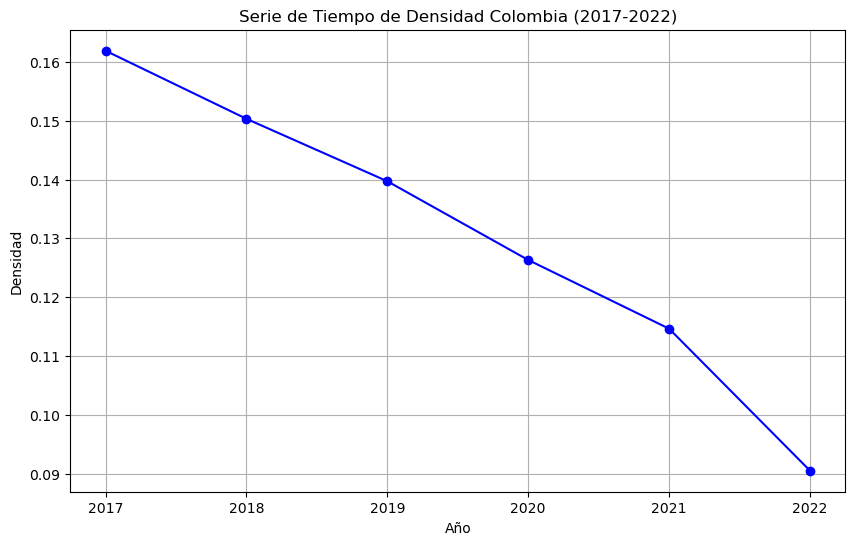

In [19]:
densidad_anio = [densidad2017, densidad2018, densidad2019, densidad2020, densidad2021, densidad2022]

df_densidad = pd.DataFrame({
    "Año": anios,
    "Densidad": densidad_anio})
df_densidad

df_densidad.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_densidad.index, df_densidad['Densidad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Densidad')
plt.title('Serie de Tiempo de Densidad Colombia (2017-2022)')
plt.grid(True)
plt.show()

### Centralización

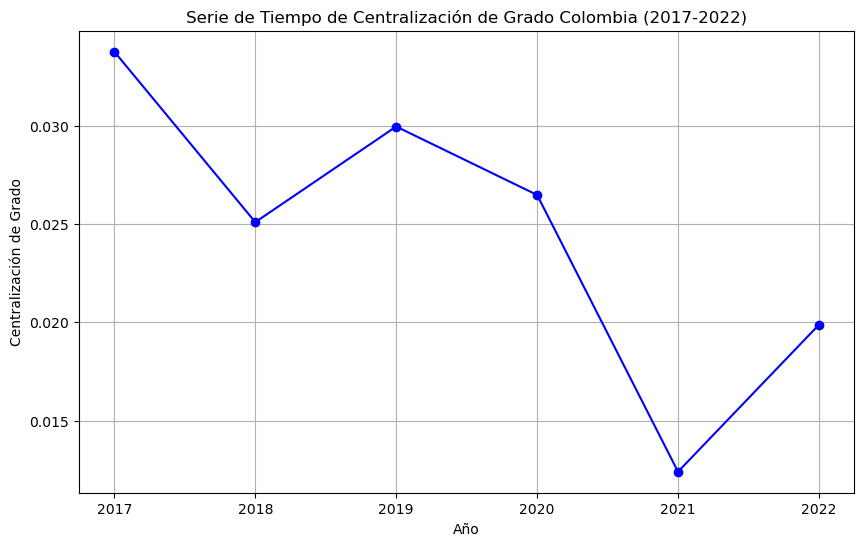

In [20]:
centralizacion_anio = [centralizacion2017, centralizacion2018, centralizacion2019, centralizacion2020, centralizacion2021, centralizacion2022]

df_centralizacion = pd.DataFrame({
    'Año': anios,
    'Centralización de Grado': centralizacion_anio})
df_centralizacion

df_centralizacion.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_centralizacion.index, df_centralizacion['Centralización de Grado'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Centralización de Grado')
plt.title('Serie de Tiempo de Centralización de Grado Colombia (2017-2022)')
plt.grid(True)
plt.show()

### Asortatividad

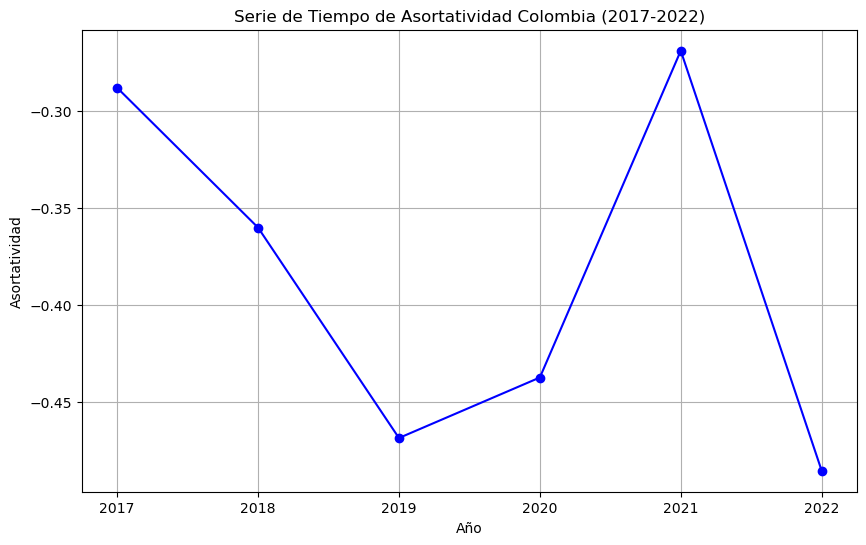

In [21]:
asort_anio = [asort2017, asort2018, asort2019, asort2020, asort2021, asort2022]

df_asort = pd.DataFrame({
    'Año': anios,
    'Asortatividad': asort_anio})

df_asort.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_asort.index, df_asort['Asortatividad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Asortatividad')
plt.title('Serie de Tiempo de Asortatividad Colombia (2017-2022)')
plt.grid(True)
plt.show()

### Transitividad

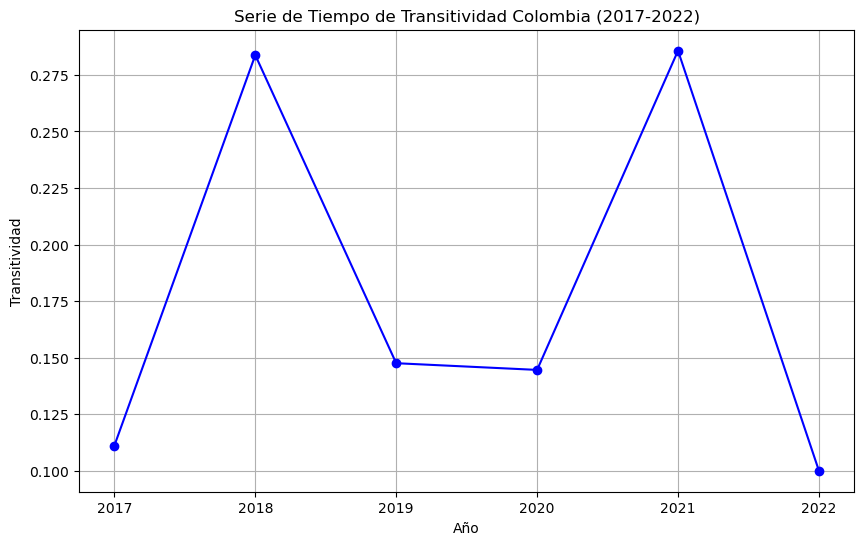

In [22]:
trans_anio = [trans2017, trans2018, trans2019, trans2020, trans2021, trans2022]

df_asort = pd.DataFrame({
    'Año': anios,
    'Transitividad': trans_anio})

df_asort.set_index('Año', inplace=True)

# Graficar la serie de tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_asort.index, df_asort['Transitividad'], marker='o', linestyle='-', color='b')
plt.xlabel('Año')
plt.ylabel('Transitividad')
plt.title('Serie de Tiempo de Transitividad Colombia (2017-2022)')
plt.grid(True)
plt.show()

### Comparación métricas


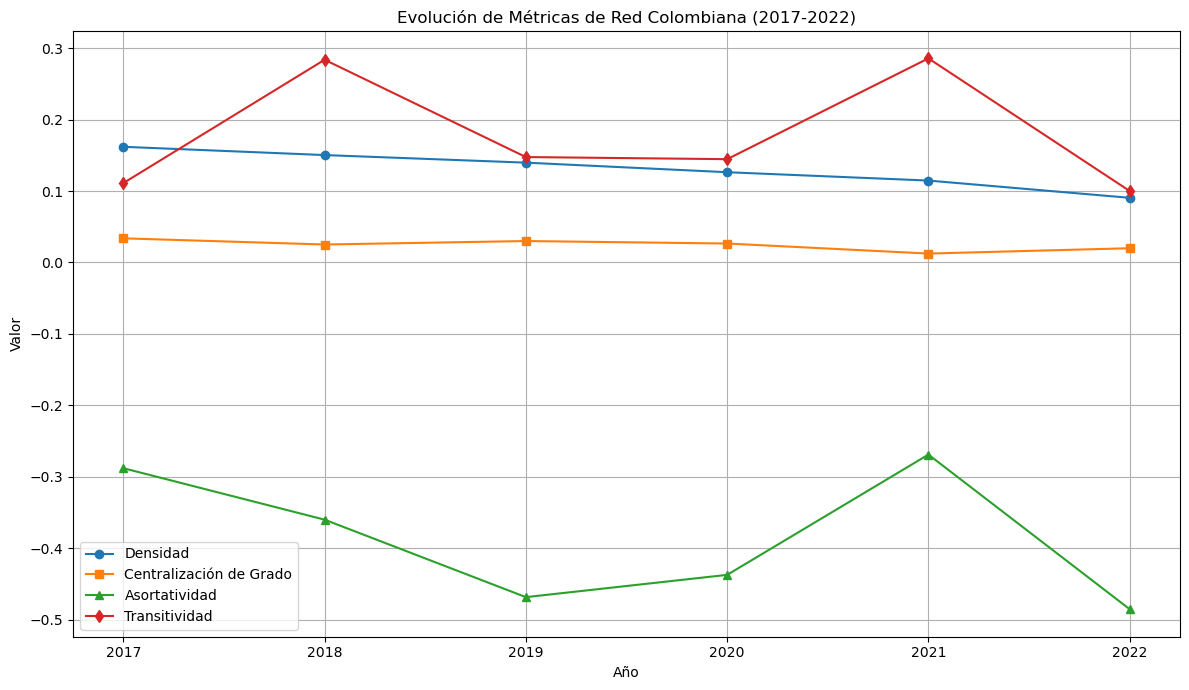

In [23]:
df = pd.DataFrame({
    'Año': anios,
    'Densidad': densidad_anio,
    'Centralización de Grado': centralizacion_anio,
    'Asortatividad': asort_anio,
    'Transitividad': trans_anio
})

df.set_index('Año', inplace=True)

plt.figure(figsize=(12, 7))
plt.plot(df.index, df['Densidad'], marker='o', label='Densidad')
plt.plot(df.index, df['Centralización de Grado'], marker='s', label='Centralización de Grado')
plt.plot(df.index, df['Asortatividad'], marker='^', label='Asortatividad')
plt.plot(df.index, df['Transitividad'], marker='d', label='Transitividad')

plt.xlabel('Año')
plt.ylabel('Valor')
plt.title('Evolución de Métricas de Red Colombiana (2017-2022)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()